# Takes ARD image products and uses the CNN model to classify into ice/water

In [1]:
from os import listdir

#Identifying the input directory
indir = r'Data/ice'

files = [f for f in listdir(indir) if f.startswith('S0') and f.endswith('.tif')]

print(files)

['S0_RS2_OK9968_PK112693_DK109010_SCWA_20100213_004158_HH_HV_SGF.tif']


In [20]:
import gdal
import numpy as np
from tensorflow.keras.models import load_model
import pandas as pd

#Loading classifier model
classifier = load_model(r'Data\SeaIceCNN_20210806.h5')

#Selecting the number of bands to use for the classification
numbands = 4

#Loading the image normalization information
means_stds = pd.read_pickle(r"Data\means_stds_S0_cnn_2021806.pkl")
means = means_stds.means.values
stds = means_stds.stds.values
print(means)
print(stds)

[-18.89616394 -27.19468498  34.27111435 -28.04409599]
[5.29300451 2.04443955 8.30415916 0.67037672]


In [4]:
#Function to resample the different bands into N x N subsamples
def resamp(arr, N):
    A = []
    for v in np.vsplit(arr, arr.shape[0] // N):
        A.extend([*np.hsplit(v, arr.shape[1] // N)])
    return np.array(A)

In [21]:
import time
from os.path import join

#Identifying the output dir
outdir = r'Data/ice'

numpix = 20

for image in files:
    
    tic = time.clock()
    
    print('Processing file: ' + image + ' ...')
    
    #Reading the processed image
    ras = gdal.Open(indir + '/' + image)
    x = ras.RasterXSize
    y = ras.RasterYSize
    
    #Creating a temporary array
    temp_array = np.empty([int(int(x/numpix)*int(y/numpix)),numpix,numpix,numbands])

    #Subsampling the image by band
    for k in np.arange(numbands):

        #Getting the band from the image
        temp_array2 = ras.GetRasterBand(int(k+1)).ReadAsArray(0, 0, 
                                                              int(int(x/numpix) * numpix), 
                                                              int(int(y/numpix) * numpix))
        #Resampling the band into 20 x 20 subsamples
        temp_array[:,:,:,k] = resamp(temp_array2, numpix)

        del temp_array2

    #Initiating an empty list of indices to remove NoData subsamples
    idx = []

    #Finding the NoData subsamples
    for i in np.arange(len(temp_array)):
        if (~np.isnan(temp_array[i,:,:,0]).any() and 
            ~np.isnan(temp_array[i,:,:,1]).any() and 
            ~np.any(temp_array[i,:,:,0]==-90) and 
            ~np.any(temp_array[i,:,:,1]==-90)):
            idx.append(i)

    #Removing the NoData subsamples
    temp_array = temp_array[idx, :, :, :]
    
    for i in np.arange(numbands):
        
        temp_array[:,:,:,i] = (temp_array[:,:,:,i] - means[i]) / stds[i]

    Y = classifier.predict(temp_array)
    
    Y2 = np.zeros([y,x], dtype = np.float32)
    Y2[:,:] = np.nan
    
    l = 0
    
    for k in idx:
        
        i = int(np.floor(k/int(x/numpix)))
        j = int(k-i*int(x/numpix))
        
        Y2[int(i*numpix):int(i*numpix)+numpix, int(j*numpix):int(j*numpix)+numpix] = Y[l]
        
        l+=1
    
    driver = gdal.GetDriverByName('GTiff')
    driver.Register()

    outDataset = driver.Create(join(outdir, image), x, y, 1, gdal.GDT_Float32)

    geoTransform = ras.GetGeoTransform()
    outDataset.SetGeoTransform(geoTransform)
    proj = ras.GetProjection()
    outDataset.SetProjection(proj)

    outband = outDataset.GetRasterBand(1)
    outband.WriteArray(Y2, 0, 0)

    outband= None
    outDataset = None
    driver = None
    ras = None
    y = None
    x = None
    X = None
    Y2 = None

    del outband, outDataset, driver, ras, x, y, X, Y2, proj, geoTransform
    
    toc = time.clock()

    print('Processing took: ' + str(toc-tic) + ' seconds')

Processing file: S0_RS2_OK9968_PK112693_DK109010_SCWA_20100213_004158_HH_HV_SGF.tif ...
Processing took: 7.835148699999991 seconds


In [22]:
from matplotlib import pyplot as plt

ras = gdal.Open(indir + '/' + image)
classes = ras.GetRasterBand(1).ReadAsArray()

[Text(1, 0, 'Ice'), Text(1, 0, 'Water')]

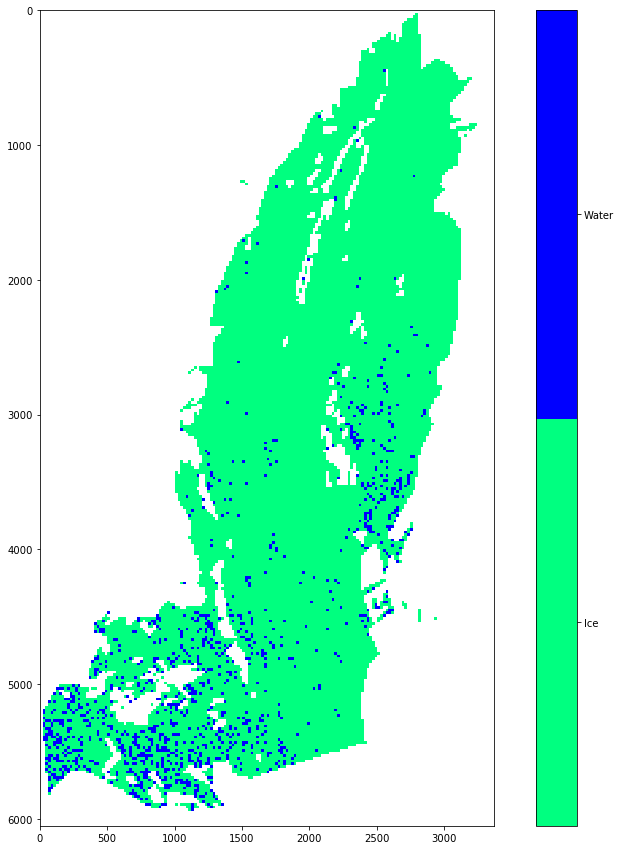

In [28]:
fig, ax = plt.subplots(figsize=(15,15))

cmap = plt.get_cmap('winter',2).reversed()

fig1 = ax.imshow(classes, cmap=cmap)
cbar = fig.colorbar(fig1, ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['Ice', 'Water'])

In [37]:
vals = classes[np.isnan(classes)==0]
acc = len(vals[vals<=0.5])/len(vals) * 100
print('Overall image accuracy is ' + "{:.2f}".format(acc) + '%')

Overall image accuracy is 94.53%
